# Gemini GNIRS reduction using DRAGONS Python API
***
## Public archival data from gnirsimg_tutorial - GN-2011B-Q-34 (GRB120116A)
#### adapted from https://dragons.readthedocs.io/projects/gnirsimg-drtutorial/en/v3.0.3/04_keyhole_api.html
#### don't forget to `conda install -n dragons nb_conda_kernels ipykernel` to run this notebook on the DRAGONS env 
***

**Importing Python Libraries** (you'll probably have to install the `wget` and `ipympl` libraries)

In [1]:
from __future__ import print_function

import glob
import wget

from gempy.adlibrary import dataselect
from recipe_system import cal_service
from recipe_system.reduction.coreReduce import Reduce
from recipe_system.utils.reduce_utils import normalize_ucals
from gempy.utils import logutils

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.colors import PowerNorm

from collections import namedtuple

#%matplotlib widget
%matplotlib inline

**Downloading the data** (direct link to .tar file hosted at Gemini - 35 Megabytes)

In [ ]:
# uncomment the line and run the cell
#
#wget.download("http://www.gemini.edu/sciops/data/software/datapkgs/gnirsimg_tutorial_datapkg-v1.tar")

**Downloading the data** (individual files - direct link to the Gemini Archive - 184 Megabytes)

In [ ]:
# # uncomment the lines and run the cell

# # Science 

# wget.download("http://archive.gemini.edu/file/N20120117S0014.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0015.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0016.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0017.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0018.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0019.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0020.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0021.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0022.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0023.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0024.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0025.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0026.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0027.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0028.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0029.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0030.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0031.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0032.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0033.fits")

# # Science darks

# wget.download("http://archive.gemini.edu/file/N20120102S0538.fits")
# wget.download("http://archive.gemini.edu/file/N20120102S0539.fits")
# wget.download("http://archive.gemini.edu/file/N20120102S0540.fits")
# wget.download("http://archive.gemini.edu/file/N20120102S0541.fits")
# wget.download("http://archive.gemini.edu/file/N20120102S0542.fits")
# wget.download("http://archive.gemini.edu/file/N20120102S0543.fits")
# wget.download("http://archive.gemini.edu/file/N20120102S0544.fits")
# wget.download("http://archive.gemini.edu/file/N20120102S0545.fits")
# wget.download("http://archive.gemini.edu/file/N20120102S0546.fits")
# wget.download("http://archive.gemini.edu/file/N20120102S0547.fits")

# # Flats (lamp-on)

# wget.download("http://archive.gemini.edu/file/N20120117S0034.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0035.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0036.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0037.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0038.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0039.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0040.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0041.fits")

# # Flats (lamp-off)

# wget.download("http://archive.gemini.edu/file/N20120117S0042.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0043.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0044.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0045.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0046.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0047.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0048.fits")
# wget.download("http://archive.gemini.edu/file/N20120117S0049.fits")


**Create and move data to raw/ directory** (uncomment first)

In [ ]:
#!mkdir raw/
#!mv N2012*.fits raw/

In [ ]:
# Check header of one raw science image
#
tmp = fits.open("raw/N20120117S0014.fits")
tmp[0].header

**Setting up the DRAGONS logger**

In [ ]:
logutils.config(file_name='gnirs_data_reduction.log')

**Setting up the Calibration Service**

First, check that you have already a `rsys.cfg` file inside the `~/.geminidr/`. It should contain:

```
[calibs]
standalone = True
database_dir = /path_to_this_folder/
```

In [ ]:
caldb = cal_service.CalibrationService()
caldb.config()
caldb.init()

cal_service.set_calservice()

**Create a list of all the FITS files in the directory**

In [ ]:
all_files = glob.glob('raw/N2012*[0-9].fits')
all_files.sort()
#all_files

**List of darks, flats, standard star, and science frames**

In [ ]:
darks60 = dataselect.select_data(
    all_files,
    ['DARK'],
    [],
    dataselect.expr_parser('exposure_time==60')
)

flats = dataselect.select_data(all_files, ['FLAT'])

target = dataselect.select_data(
    all_files,
    [],
    [],
    dataselect.expr_parser('object=="GRB120116A"')
)

**Create Master Dark and add to the calibration database**

In [ ]:
reduce_darks = Reduce()
reduce_darks.files.extend(darks60)
reduce_darks.runr()

caldb.add_cal(reduce_darks.output_filenames[0])

**Create Master Flat Field and add to the calibration database**

In [ ]:
reduce_flats = Reduce()
reduce_flats.files.extend(flats)
reduce_flats.runr()

caldb.add_cal(reduce_flats.output_filenames[0])

In [ ]:
#!showpars raw/N20120117S0014.fits associateSky

**Reduce Science Images**

In [ ]:
mycalibrations = ['processed_dark:N20120102S0538_dark.fits']

reduce_target = Reduce()
reduce_target.files.extend(target)
ucals_dict = normalize_ucals(reduce_target.files, mycalibrations)
reduce_target.ucals = ucals_dict
reduce_target.runr()

**Display the Stacked Image**

In [2]:
image_file = "N20120117S0014_image.fits"
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: N20120117S0014_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     206   ()      
  1  SCI           1 ImageHDU        50   (1287, 1047)   float32   
  2  VAR           1 ImageHDU        50   (1287, 1047)   float32   
  3  DQ            1 ImageHDU        52   (1287, 1047)   int16 (rescales to uint16)   
  4  PROVENANCE    1 BinTableHDU     21   22R x 4C   [28A, 128A, 128A, 128A]   
  5  PROVHISTORY    1 BinTableHDU     21   19R x 4C   [128A, 428A, 28A, 28A]   


In [3]:
image_data = fits.getdata(image_file, ext=1)
print(image_data.shape)

(1047, 1287)


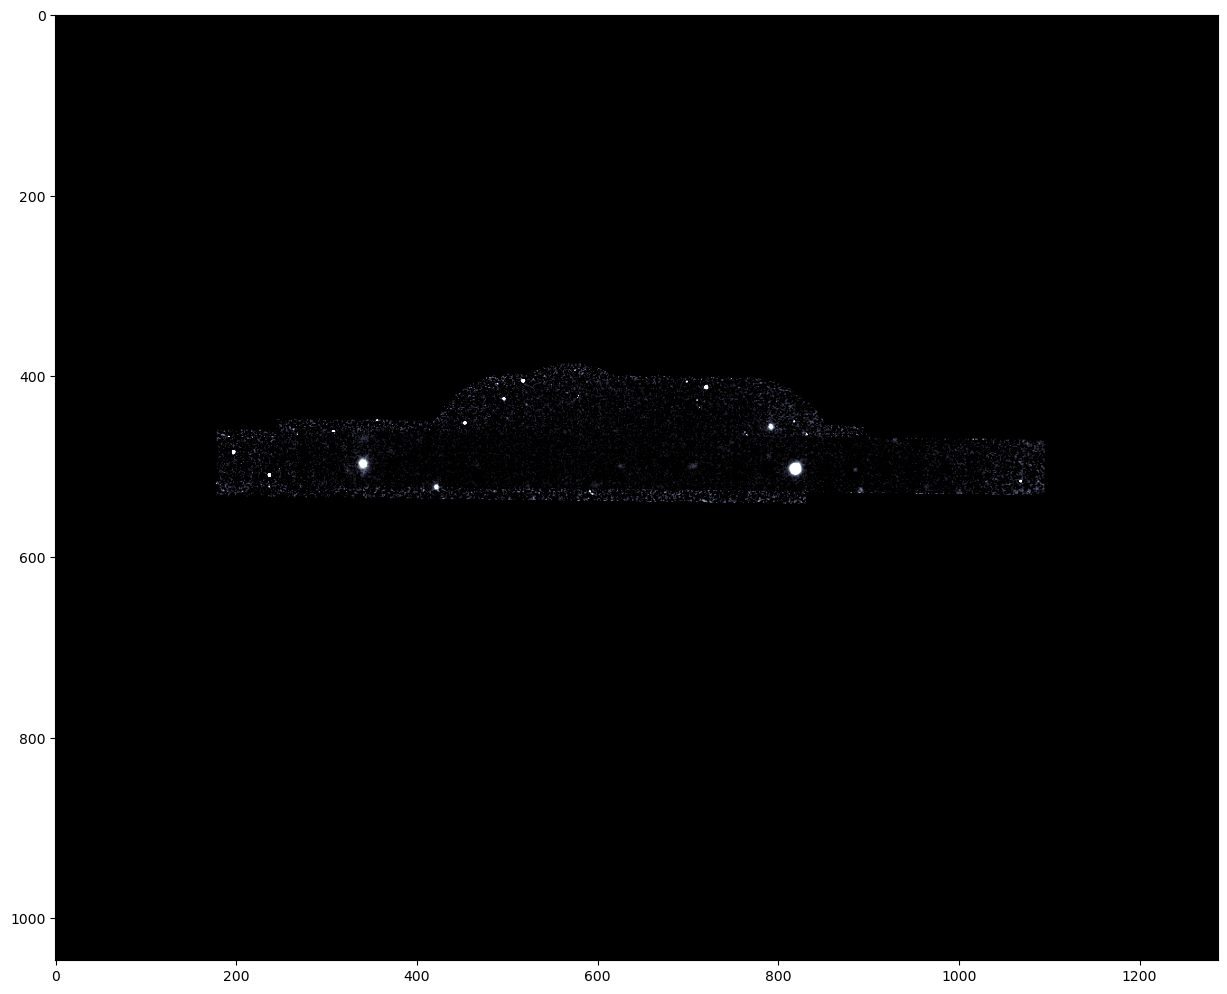

In [4]:
plt.figure(figsize = (15,15))
plt.imshow(image_data,cmap='bone',norm=Normalize(vmin=1, vmax=500))
#plt.xlim(900,2500)
#plt.ylim(1600,600)
plt.show()

**Optional: remove raw data (uncomment lines before running)**

In [ ]:
#!rm -rf raw/